In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import re
import seaborn as sns

In [2]:
# Creating a function to calculate genetic diversity among pairs
def average_diversity(genomes, num_pairs):
    # Select random pairs of indices
    random_indices = random.sample(range(len(genomes)), 2 * num_pairs)

    # Initialize a counter for differences
    differences_count = 0

    # Compare strings in random pairs
    for i in range(0, len(random_indices), 2):
        index1, index2 = random_indices[i], random_indices[i + 1]
        string1, string2 = genomes.iloc[index1], genomes.iloc[index2]

        # Compare strings and count differences
        differences_count = differences_count + sum(c1 != c2 for c1, c2 in zip(string1, string2))

    # Calculate the average differences per pair
    average_differences = differences_count / num_pairs

    return average_differences



In [3]:
# List of folder paths
folder_paths = ['/Users/gb4818/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Rev-res-in/1over5/mh',
    '/Users/gb4818/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Rev-res-in/1over10/mh',
    '/Users/gb4818/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Rev-res-in/1over25/mh',
    '/Users/gb4818/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Rev-res-in/1over50/mh',
    '/Users/gb4818/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Rev-res-in/1over100/mh',
    '/Users/gb4818/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Rev-res-in/1over200/mh',]
# Define folder labels
folder_labels = ['w=5', 'w=10', 'w=25', 'w=50', 'w=100', 'w=200']


# Initialize an empty list to store dictionaries
results_list = []

for i, folder_path in enumerate(folder_paths):
    # Loop through files in the folder
    for filename in os.listdir(folder_path):
        match = re.match(r'REvoSim_individuals_data_(\d+).txt', filename)
        if match:
            file_path = os.path.join(folder_path, filename)
            
            # Print the DataFrame for debugging
            df = pd.read_csv(file_path, sep=',', header=0, skiprows=12)
            genomes = df['Genome']
          
            # Calculate average differences for the current file
            diversity = average_diversity(genomes, len(genomes)//2)

            # Append dictionary to the list
            result_dict = {'File': filename, 'Folder': folder_labels[i], 'AverageDiversity': diversity, 'Pairs':len(genomes)//2}
            results_list.append(result_dict)

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results_list)
mean_div_env = results_df.groupby('Folder')['AverageDiversity'].mean().reset_index()

/var/folders/dm/ryjvp3j51h78gsbgf92k6xvh0000gp/T/ipykernel_42510/2294222545.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Folder', y='AverageDiversity', data=results_df, alpha=0.5, palette='viridis')


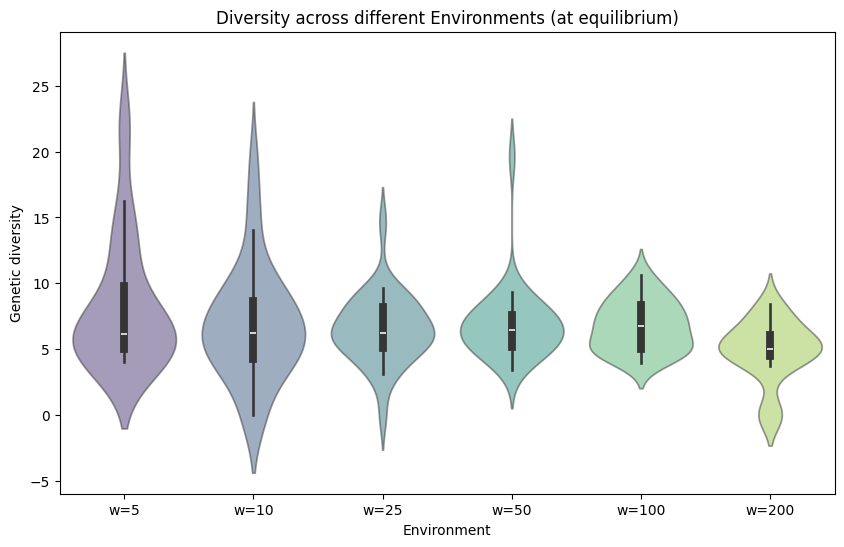

In [9]:
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Folder', y='AverageDiversity', data=results_df, alpha=0.5, palette='viridis')

# Labels
plt.xlabel('Environment')
plt.ylabel('Genetic diversity')
plt.title('Diversity across different Environments (at equilibrium)')
plt.show()

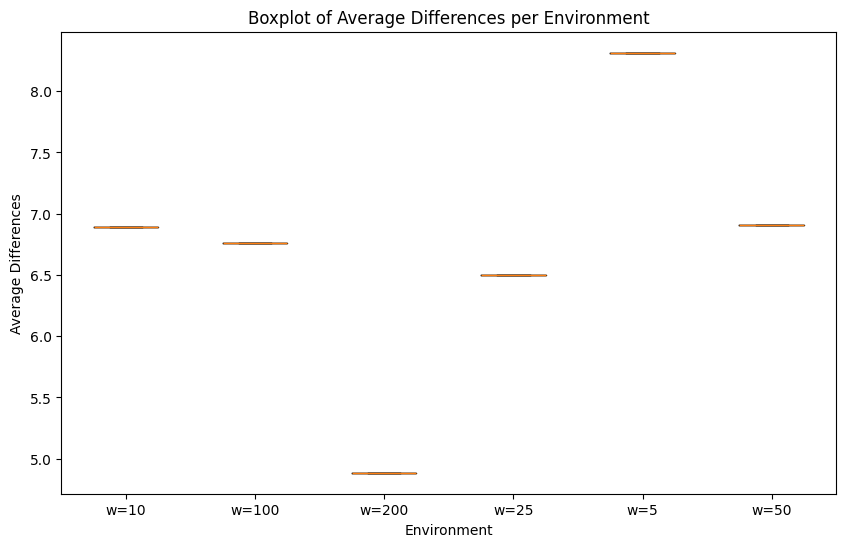

In [5]:
plt.figure(figsize=(10,6))
plt.boxplot([group['AverageDiversity'] for name, group in mean_div_env.groupby('Folder')],
            labels=mean_div_env['Folder'])
plt.xlabel('Environment')
plt.ylabel('Average Differences')
plt.title('Boxplot of Average Differences per Environment')

plt.show()